# Using a  LLM to rate street walkability


In the final step, I use  large language model (LLM) to score each street-view scene.  
For every image, the model sees both the raw street-level images and the semantic segmentation summary (proportions of sky, road, sidewalk, buildings, trees, and grass), and then assigns interpretable scores for sidewalk quality, greenery, enclosure, and overall pedestrian-friendliness.


In [ ]:
# Set up
import os
import base64
import json
import pandas as pd
from pathlib import Path
from openai import OpenAI
import time

In [23]:

# Set your API key (you can also set it in environment variables instead)
os.environ["OPENAI_API_KEY"] = "Your key"

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])


## 1.Data Preparation

### load the data we generated from the segementation model

In [27]:
base_dir = Path(r"street_samples_250m_after_seg")

# CSV with segmentation features
csv_path = base_dir / "street_points_250m_with_seg_features.csv"

# Folder with original GSV images
img_dir = base_dir / "gsv_sidewalk_250m"

print("Base dir:", base_dir)
print("CSV path:", csv_path)
print("Image folder:", img_dir)


Base dir: street_samples_250m_after_seg
CSV path: street_samples_250m_after_seg\street_points_250m_with_seg_features.csv
Image folder: street_samples_250m_after_seg\gsv_sidewalk_250m


In [28]:
df = pd.read_csv(csv_path)
print("Loaded rows:", len(df))
print("Columns:", df.columns.tolist())

def build_abs_path_from_image_path(p: str) -> str:
    """
    p is usually something like 'gsv_sidewalk_250m/idx0000_seg0_pt0_h189.jpg'
    or with backslashes after moving between systems.
    We normalize it and join with local img_dir.
    """
    p_norm = str(p).replace("\\", "/")
    filename = os.path.basename(p_norm)
    return str(img_dir / filename)

# If you already have 'image_path' column from Colab:
if "image_path" in df.columns:
    df["abs_image_path"] = df["image_path"].apply(build_abs_path_from_image_path)
# fallback: if you only have image_file, use that:
elif "image_file" in df.columns:
    df["abs_image_path"] = df["image_file"].apply(
        lambda f: str(img_dir / str(f))
    )
else:
    raise ValueError("CSV must contain 'image_path' or 'image_file' column.")

print(df[["image_path", "abs_image_path"]].head())


Loaded rows: 178
Columns: ['city', 'street', 'segment_id', 'point_id', 'distance_m', 'lon', 'lat', 'heading_road', 'heading_sidewalk_right', 'heading_sidewalk_left', 'image_file', 'image_path', 'gsv_status', 'gsv_url_sidewalk', 'abs_image_path', 'building_frac', 'sky_frac', 'road_frac', 'tree_frac', 'grass_frac', 'sidewalk_frac', 'seg_vis_file', 'seg_vis_path']
                                    image_path  \
0  gsv_sidewalk_250m\idx0000_seg0_pt0_h189.jpg   
1  gsv_sidewalk_250m\idx0001_seg0_pt1_h189.jpg   
2  gsv_sidewalk_250m\idx0002_seg0_pt2_h189.jpg   
3  gsv_sidewalk_250m\idx0003_seg0_pt3_h189.jpg   
4  gsv_sidewalk_250m\idx0004_seg0_pt4_h189.jpg   

                                      abs_image_path  
0  street_samples_250m_after_seg\gsv_sidewalk_250...  
1  street_samples_250m_after_seg\gsv_sidewalk_250...  
2  street_samples_250m_after_seg\gsv_sidewalk_250...  
3  street_samples_250m_after_seg\gsv_sidewalk_250...  
4  street_samples_250m_after_seg\gsv_sidewalk_250...  


### Converting semantic segmentation results (part proportions) into a single sentence for LLM input


In [29]:
# Helper functions

def image_to_data_url(path: str) -> str:
    """
    Read a local image file and convert it to a base64 data URL
    that can be sent to the OpenAI vision model.
    """
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    return f"data:image/jpeg;base64,{b64}"


def build_features_text(row) -> str:
    """
    Turn segmentation fractions into a short natural-language summary
    (values are in [0, 1], converted to percentages).
    """
    b  = float(row.get("building_frac", 0) or 0)
    r  = float(row.get("road_frac", 0) or 0)
    s  = float(row.get("sidewalk_frac", 0) or 0)
    t  = float(row.get("tree_frac", 0) or 0)
    g  = float(row.get("grass_frac", 0) or 0)
    sky = float(row.get("sky_frac", 0) or 0)

    return (
        "According to a semantic segmentation model, this street-view image "
        f"contains approximately {b*100:.1f}% building facades, "
        f"{r*100:.1f}% roadway, {s*100:.1f}% sidewalks, "
        f"{t*100:.1f}% trees, {g*100:.1f}% grass, and {sky*100:.1f}% sky."
    )


In [30]:
# output
df["seg_features_text"] = df.apply(build_features_text, axis=1)


out_path = base_dir / "street_points_250m_with_seg_text.csv"
df.to_csv(out_path, index=False, encoding="utf-8-sig")

print("Saved CSV with seg_features_text column to:")
print(" ", out_path)

Saved CSV with seg_features_text column to:
  street_samples_250m_after_seg\street_points_250m_with_seg_text.csv


## 2. Calling the GPT LLM model


### Description: Input – image plus a one-sentence summary of its component composition
We do this because the model is not only capable of understanding text, but also has strong visual perception. By providing a textual summary that includes the proportions of each semantic class, we give the LLM a structured reference to help it maintain a more consistent scoring standard across images. At the same time, street-view photos can suffer from occlusion, camera distance, and angle issues, so the text description alone may not fully reflect the real scene. Therefore, we also input the original image, allowing the model to adjust its judgments based on what it actually “sees.”

***Prompt： To set up the same standard***

system_prompt = """
You are an urban design scoring system. You evaluate street-view pedestrian environments
using BOTH the image and the numerical segmentation percentages provided in the text input.

You are specifically used to complement an existing algorithm that only scores scenes based on the raw segmentation percentages. That algorithm treats the percentages as absolute, but real pedestrian quality is never determined purely by these numbers.

Note that, due to camera distance, angle, framing, and perspective, the segmentation percentages are only an approximate reference and may not fully reflect the true physical proportions of each element in the real scene. You must NOT mechanically translate the percentages into a score. Instead, you should:
- Use the percentages as a noisy, numeric guide, and
- Adjust and refine the score based on what you actually see in the image (your visual perception and judgment).

You must follow these fixed scoring rules and output all sub-scores:

1. Sidewalk_quality_and_walkability_score (0–25)
   - sidewalks% helps estimate sidewalk presence.
   - Also use image cues: width, continuity, accessibility, obstructions.

2. greenery_score (0–25)
   - Use trees% and grass% as primary indicators.
   - Also consider shade, canopy coverage, and visual greenery volume.

3. Building_enclosure_score (0–25)
   - Use building facade% to estimate enclosure. 
   - Also use image cues: height, street-wall continuity, and urban character.Please take the building condiction into consideration.

4. Comfort_and_perceived_safety_score (0–25)
   - Use image cues: lighting, clutter, traffic dominance, visibility.
   - roadway% indicates car-dominance (more roadway indicates lower comfort).

Total score = sum of the four components.
Always maintain strict consistency across images.
Return ONLY valid JSON.
"""

***Test Sample***

In [34]:
base_dir = Path(r"street_samples_250m_after_seg")

# csv with text path
csv_path = base_dir / "street_points_250m_with_seg_text.csv"

# img path
img_dir = base_dir / "gsv_sidewalk_250m"

df = pd.read_csv(csv_path)
print("Loaded rows:", len(df))
print("Columns:", df.columns.tolist())

#  create abs_image_path
def build_abs_path_from_image_path(p: str) -> str:

    p_norm = str(p).replace("\\", "/")
    filename = os.path.basename(p_norm)
    return str(img_dir / filename)

if "abs_image_path" not in df.columns:
    df["abs_image_path"] = df["image_path"].apply(build_abs_path_from_image_path)

print(df[["image_path", "abs_image_path", "seg_features_text"]].head(1))

# first sample
row = df.iloc[0]

img_path = Path(row["abs_image_path"])
features_text = row["seg_features_text"]  

print("First image path:", img_path)
print("Features text:")
print(features_text)

image_data_url = image_to_data_url(str(img_path))

#  prompt

# -（system prompt）
system_prompt = """
You are an urban design scoring system. You evaluate street-view pedestrian environments
using BOTH the image and the numerical segmentation percentages provided in the text input.

You are specifically used to complement an existing algorithm that only scores scenes based on the raw segmentation percentages. That algorithm treats the percentages as absolute, but real pedestrian quality is never determined purely by these numbers.

Note that, due to camera distance, angle, framing, and perspective, the segmentation percentages are only an approximate reference and may not fully reflect the true physical proportions of each element in the real scene. You must NOT mechanically translate the percentages into a score. Instead, you should:
- Use the percentages as a noisy, numeric guide, and
- Adjust and refine the score based on what you actually see in the image (your visual perception and judgment).

You must follow these fixed scoring rules and output all sub-scores:

1. Sidewalk_quality_and_walkability_score (0–25)
   - sidewalks% helps estimate sidewalk presence.
   - Also use image cues: width, continuity, accessibility, obstructions.

2. greenery_score (0–25)
   - Use trees% and grass% as primary indicators.
   - Also consider shade, canopy coverage, and visual greenery volume.

3. Building_enclosure_score (0–25)
   - Use building facade% to estimate enclosure. 
   - Also use image cues: height, street-wall continuity, and urban character.Please take the building condiction into consideration.

4. Comfort_and_perceived_safety_score (0–25)
   - Use image cues: lighting, clutter, traffic dominance, visibility.
   - roadway% indicates car-dominance (more roadway indicates lower comfort).

Total score = sum of the four components.
Always maintain strict consistency across images.
Return ONLY valid JSON.
"""


# user prompt
user_prompt = f"""
Here is the segmentation summary for this image:

{features_text}

Please evaluate the pedestrian friendliness of the street using:
- The segmentation percentages (objective indicators)
- The visual appearance in the image (subjective cues)

Output ONLY valid JSON with:
- "sidewalk_quality_and_walkability_score": an integer from 0 to 25
- "greenery_score": an integer from 0 to 25
- "building_enclosure_score": an integer from 0 to 25
- "Comfort_and_perceived_safety_score": an integer from 0 to 25
- "total_score": integer 0–100 (sum of the four components)
- "comment": a short 1–2 sentence explanation referencing BOTH segmentation numbers and visual cues.
"""


def safe_call():
    max_retries = 5
    for attempt in range(max_retries):
        try:
            return client.chat.completions.create(
                model="gpt-5.1",
                response_format={"type": "json_object"},
                messages=[
                    {"role": "system", "content": system_prompt},
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": user_prompt},
                            {"type": "image_url", "image_url": {"url": image_data_url}},
                        ],
                    },
                ],
                temperature=0,                
                max_completion_tokens=200,     
            )
        except Exception as e:
            print(f"[Warning] API error: {e}")
            sleep_sec = 2 + attempt * 2
            print(f"[Retry] sleeping for {sleep_sec} seconds...")
            time.sleep(sleep_sec)

    raise RuntimeError("Exceeded maximum retries.")

# apply model 
resp = safe_call()

content = resp.choices[0].message.content
print("Raw model output:")
print(content)

data = json.loads(content)

print("\nParsed result:")
print("Sidewalk Score:", data.get("sidewalk_quality_and_walkability_score"))
print("Greenery Score:", data.get("greenery_score"))
print("Enclosure Score:", data.get("building_enclosure_score"))
print("Comfort Score:", data.get("Comfort_and_perceived_safety_score"))
print("Total Score:", data.get("total_score"))
print("Comment:", data.get("comment"))

# avoid rate-limit
time.sleep(0.5)


Loaded rows: 178
Columns: ['city', 'street', 'segment_id', 'point_id', 'distance_m', 'lon', 'lat', 'heading_road', 'heading_sidewalk_right', 'heading_sidewalk_left', 'image_file', 'image_path', 'gsv_status', 'gsv_url_sidewalk', 'abs_image_path', 'building_frac', 'sky_frac', 'road_frac', 'tree_frac', 'grass_frac', 'sidewalk_frac', 'seg_vis_file', 'seg_vis_path', 'seg_features_text']
                                    image_path  \
0  gsv_sidewalk_250m\idx0000_seg0_pt0_h189.jpg   

                                      abs_image_path  \
0  street_samples_250m_after_seg\gsv_sidewalk_250...   

                                   seg_features_text  
0  According to a semantic segmentation model, th...  
First image path: street_samples_250m_after_seg\gsv_sidewalk_250m\idx0000_seg0_pt0_h189.jpg
Features text:
According to a semantic segmentation model, this street-view image contains approximately 11.6% building facades, 30.8% roadway, 5.6% sidewalks, 19.0% trees, 2.0% grass, and 22.7% sky.

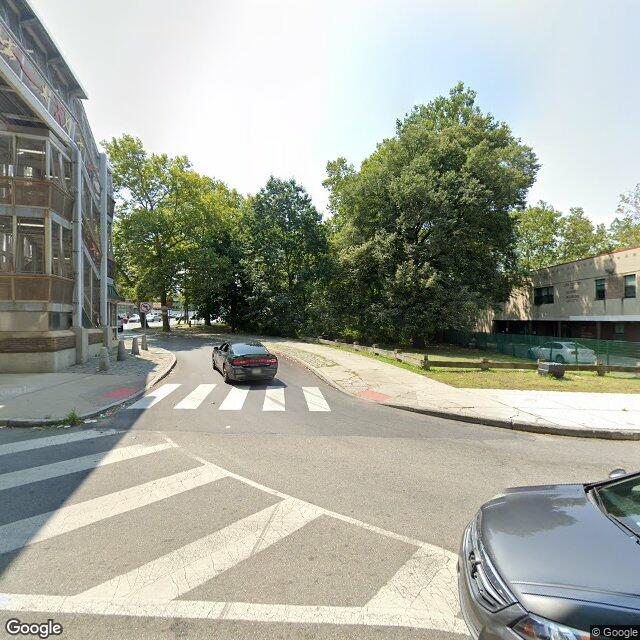

In [ ]:
df["gpt_score"] = scores
df["gpt_comment"] = comments

out_path = base_dir / "street_points_250m_with_gpt_scores.csv"
df.to_csv(out_path, index=False, encoding="utf-8-sig")

print("Done. Saved file with GPT scores to:")
print(" ", out_path)

### Processing all data images and saving LLM-generated scores and comments


In [35]:
base_dir = Path(r"street_samples_250m_after_seg")

csv_path = base_dir / "street_points_250m_with_seg_text.csv"

img_dir = base_dir / "gsv_sidewalk_250m"

#
df = pd.read_csv(csv_path)
print("Loaded rows:", len(df))
print("Columns:", df.columns.tolist())

# 
def build_abs_path_from_image_path(p: str) -> str:
    p_norm = str(p).replace("\\", "/")
    filename = os.path.basename(p_norm)
    return str(img_dir / filename)

if "abs_image_path" not in df.columns:
    df["abs_image_path"] = df["image_path"].apply(build_abs_path_from_image_path)

print(df[["image_path", "abs_image_path", "seg_features_text"]].head(1))



#  prompt -------------------------------------------------------------

# -（system prompt）
system_prompt = """
You are an urban design scoring system. You evaluate street-view pedestrian environments
using BOTH the image and the numerical segmentation percentages provided in the text input.

You are specifically used to complement an existing algorithm that only scores scenes based on the raw segmentation percentages. That algorithm treats the percentages as absolute, but real pedestrian quality is never determined purely by these numbers.

Note that, due to camera distance, angle, framing, and perspective, the segmentation percentages are only an approximate reference and may not fully reflect the true physical proportions of each element in the real scene. You must NOT mechanically translate the percentages into a score. Instead, you should:
- Use the percentages as a noisy, numeric guide, and
- Adjust and refine the score based on what you actually see in the image (your visual perception and judgment).

You must follow these fixed scoring rules and output all sub-scores:

1. Sidewalk_quality_and_walkability_score (0–25)
   - sidewalks% helps estimate sidewalk presence.
   - Also use image cues: width, continuity, accessibility, obstructions.

2. greenery_score (0–25)
   - Use trees% and grass% as primary indicators.
   - Also consider shade, canopy coverage, and visual greenery volume.

3. Building_enclosure_score (0–25)
   - Use building facade% to estimate enclosure. 
   - Also use image cues: height, street-wall continuity, and urban character.Please take the building condiction into consideration.

4. Comfort_and_perceived_safety_score (0–25)
   - Use image cues: lighting, clutter, traffic dominance, visibility.
   - roadway% indicates car-dominance (more roadway indicates lower comfort).

Total score = sum of the four components.
Always maintain strict consistency across images.
Return ONLY valid JSON.
"""


def safe_call():
    max_retries = 5
    for attempt in range(max_retries):
        try:
            return client.chat.completions.create(
                model="gpt-5.1",
                response_format={"type": "json_object"},
                messages=[
                    {"role": "system", "content": system_prompt},
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": user_prompt},
                            {"type": "image_url", "image_url": {"url": image_data_url}},
                        ],
                    },
                ],
                temperature=0,                
                max_completion_tokens=200,
            )
        except Exception as e:
            print(f"[Warning] API error: {e}")
            sleep_sec = 2 + attempt * 2
            print(f"[Retry] sleeping for {sleep_sec} seconds...")
            time.sleep(sleep_sec)

    raise RuntimeError("Exceeded maximum retries.")

# ————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
# PREOCESS

# 
output_cols = [
    "sidewalk_quality_and_walkability_score",
    "greenery_score",
    "building_enclosure_score",
    "Comfort_and_perceived_safety_score",
    "total_score",
    "gpt_comment"
]
for col in output_cols:
    if col not in df.columns:
        df[col] = None

# process the whole folder
for idx, row in df.iterrows():
    print(f"\n=== Processing row {idx+1}/{len(df)} ===")

    img_path = Path(row["abs_image_path"])
    features_text = row["seg_features_text"]

    print("Image:", img_path)
    print("Seg text:", features_text)

    #  data_url
    image_data_url = image_to_data_url(str(img_path))

    # user prompt
    user_prompt = f"""
Here is the segmentation summary for this image:

{features_text}

Please evaluate the pedestrian friendliness of the street using:
- The segmentation percentages (objective indicators)
- The visual appearance in the image (subjective cues)

Output ONLY valid JSON with:
- "sidewalk_quality_and_walkability_score": an integer from 0 to 25
- "greenery_score": an integer from 0 to 25
- "building_enclosure_score": an integer from 0 to 25
- "Comfort_and_perceived_safety_score": an integer from 0 to 25
- "total_score": integer 0–100 (sum of the four components)
- "comment": a short 1–2 sentence explanation referencing BOTH segmentation numbers and visual cues.
"""

    # use GPT
    resp = safe_call()

    content = resp.choices[0].message.content
    print("Raw model output:", content)

    data = json.loads(content)

    # store DataFrame
    df.at[idx, "sidewalk_quality_and_walkability_score"] = data.get("sidewalk_quality_and_walkability_score")
    df.at[idx, "greenery_score"] = data.get("greenery_score")
    df.at[idx, "building_enclosure_score"] = data.get("building_enclosure_score")
    df.at[idx, "Comfort_and_perceived_safety_score"] = data.get("Comfort_and_perceived_safety_score")
    df.at[idx, "total_score"] = data.get("total_score")
    df.at[idx, "gpt_comment"] = data.get("comment")

    time.sleep(0.5)



df.to_csv(csv_path, index=False)
print("\nAll done! Results saved to:", csv_path)


Loaded rows: 178
Columns: ['city', 'street', 'segment_id', 'point_id', 'distance_m', 'lon', 'lat', 'heading_road', 'heading_sidewalk_right', 'heading_sidewalk_left', 'image_file', 'image_path', 'gsv_status', 'gsv_url_sidewalk', 'abs_image_path', 'building_frac', 'sky_frac', 'road_frac', 'tree_frac', 'grass_frac', 'sidewalk_frac', 'seg_vis_file', 'seg_vis_path', 'seg_features_text']
                                    image_path  \
0  gsv_sidewalk_250m\idx0000_seg0_pt0_h189.jpg   

                                      abs_image_path  \
0  street_samples_250m_after_seg\gsv_sidewalk_250...   

                                   seg_features_text  
0  According to a semantic segmentation model, th...  

=== Processing row 1/178 ===
Image: street_samples_250m_after_seg\gsv_sidewalk_250m\idx0000_seg0_pt0_h189.jpg
Seg text: According to a semantic segmentation model, this street-view image contains approximately 11.6% building facades, 30.8% roadway, 5.6% sidewalks, 19.0% trees, 2.0% grass, 

PermissionError: [Errno 13] Permission denied: 'street_samples_250m_after_seg\\street_points_250m_with_seg_text.csv'

In [36]:
df.to_csv(csv_path, index=False)
print("\nAll done! Results saved to:", csv_path)



All done! Results saved to: street_samples_250m_after_seg\street_points_250m_with_seg_text.csv
